In [1]:
import os

from matplotlib import pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

In [2]:
[file for file in os.listdir(os.getcwd()) if not file.startswith('.')]

['main.py', 'in', 'spark_notebook.ipynb', 'venv', 'test.txt']

In [3]:
sparkSession = SparkSession.builder \
    .master('local[*]') \
    .appName('pysparkTest') \
    .config('spark.executor.memory', '1gb') \
    .getOrCreate()

sc = sparkSession.sparkContext
sqlCtx = SQLContext(sc)

In [4]:
rdd = sc.textFile('in/cal_housing.data')
header = sc.textFile('in/cal_housing.domain')

In [5]:
haeder_str_repr = header.collect()
print(rdd.take(1))

['-122.230000,37.880000,41.000000,880.000000,129.000000,322.000000,126.000000,8.325200,452600.000000']


In [6]:
rdd = rdd.map(lambda v: v.split(','))

In [7]:
[dict(zip(haeder_str_repr, raw_data)) for raw_data in rdd.take(2)]

[{'longitude: continuous.': '-122.230000',
  'latitude: continuous.': '37.880000',
  'housingMedianAge: continuous. ': '41.000000',
  'totalRooms: continuous. ': '880.000000',
  'totalBedrooms: continuous. ': '129.000000',
  'population: continuous. ': '322.000000',
  'households: continuous. ': '126.000000',
  'medianIncome: continuous. ': '8.325200',
  'medianHouseValue: continuous. ': '452600.000000'},
 {'longitude: continuous.': '-122.220000',
  'latitude: continuous.': '37.860000',
  'housingMedianAge: continuous. ': '21.000000',
  'totalRooms: continuous. ': '7099.000000',
  'totalBedrooms: continuous. ': '1106.000000',
  'population: continuous. ': '2401.000000',
  'households: continuous. ': '1138.000000',
  'medianIncome: continuous. ': '8.301400',
  'medianHouseValue: continuous. ': '358500.000000'}]

In [8]:
from pyspark.sql import Row


rdd = rdd.map(lambda v: Row(longitude=v[0], 
                            latitude=v[1], 
                            housingMedianAge=v[2], 
                            totalRooms=v[3],
                            totalBedrooms=v[4], 
                            population=v[5], 
                            households=v[6], 
                            medianIncome=v[7], 
                            medianHouseValue=v[8]))

In [9]:
rdd.first()

Row(longitude='-122.230000', latitude='37.880000', housingMedianAge='41.000000', totalRooms='880.000000', totalBedrooms='129.000000', population='322.000000', households='126.000000', medianIncome='8.325200', medianHouseValue='452600.000000')

In [10]:
df = rdd.toDF()
print(df.printSchema())
df.show(10)

root
 |-- longitude: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- housingMedianAge: string (nullable = true)
 |-- totalRooms: string (nullable = true)
 |-- totalBedrooms: string (nullable = true)
 |-- population: string (nullable = true)
 |-- households: string (nullable = true)
 |-- medianIncome: string (nullable = true)
 |-- medianHouseValue: string (nullable = true)

None
+-----------+---------+----------------+-----------+-------------+-----------+-----------+------------+----------------+
|  longitude| latitude|housingMedianAge| totalRooms|totalBedrooms| population| households|medianIncome|medianHouseValue|
+-----------+---------+----------------+-----------+-------------+-----------+-----------+------------+----------------+
|-122.230000|37.880000|       41.000000| 880.000000|   129.000000| 322.000000| 126.000000|    8.325200|   452600.000000|
|-122.220000|37.860000|       21.000000|7099.000000|  1106.000000|2401.000000|1138.000000|    8.301400|   358500.

In [11]:
from pyspark.sql.types import FloatType


def convert_columns(df, columns, custom_type):
    for column in columns:
        df = df.withColumn(column, df[column].cast(custom_type()))
    return df

In [12]:
df = convert_columns(df, df.columns, FloatType)
df.printSchema()

root
 |-- longitude: float (nullable = true)
 |-- latitude: float (nullable = true)
 |-- housingMedianAge: float (nullable = true)
 |-- totalRooms: float (nullable = true)
 |-- totalBedrooms: float (nullable = true)
 |-- population: float (nullable = true)
 |-- households: float (nullable = true)
 |-- medianIncome: float (nullable = true)
 |-- medianHouseValue: float (nullable = true)



In [13]:
df.select('longitude', 'latitude', 'population', 'totalRooms').show(10)

+---------+--------+----------+----------+
|longitude|latitude|population|totalRooms|
+---------+--------+----------+----------+
|  -122.23|   37.88|     322.0|     880.0|
|  -122.22|   37.86|    2401.0|    7099.0|
|  -122.24|   37.85|     496.0|    1467.0|
|  -122.25|   37.85|     558.0|    1274.0|
|  -122.25|   37.85|     565.0|    1627.0|
|  -122.25|   37.85|     413.0|     919.0|
|  -122.25|   37.84|    1094.0|    2535.0|
|  -122.25|   37.84|    1157.0|    3104.0|
|  -122.26|   37.84|    1206.0|    2555.0|
|  -122.25|   37.84|    1551.0|    3549.0|
+---------+--------+----------+----------+
only showing top 10 rows



In [14]:
grouped_example = df.groupby('housingMedianAge').count().sort('housingMedianAge', ascending=True).take(100)

Text(0, 0.5, 'Median age')

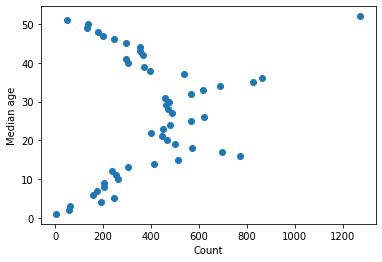

In [15]:
count = []
median_age = []

for row in grouped_example:
    row_dict = row.asDict()
    cnt = row_dict['count']
    age = row_dict['housingMedianAge']
    count.append(cnt)
    median_age.append(age)
    
plt.scatter(count, median_age)
plt.xlabel('Count')
plt.ylabel('Median age')

In [16]:
df.registerTempTable('tmp_df')
print('Created tables:')
print(' '.join([row.tableName for row in sqlCtx.tables().collect()]))

_sql = """
select housingMedianAge, avg(totalRooms) as avg_rooms
from tmp_df 
group by housingMedianAge 
order by avg_rooms
"""

tmp_df_grouped = sqlCtx.sql(_sql).take(100)

Created tables:
tmp_df


Text(0, 0.5, 'Median age')

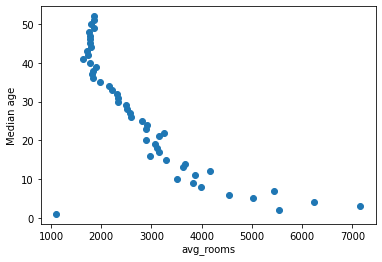

In [17]:
avg_rooms = []
median_age_2 = []

for row in tmp_df_grouped:
    row_dict = row.asDict()
    avg_room = row_dict['avg_rooms']
    age = row_dict['housingMedianAge']
    avg_rooms.append(avg_room)
    median_age_2.append(age)
    
plt.scatter(avg_rooms, median_age_2)
plt.xlabel('avg_rooms')
plt.ylabel('Median age')

In [18]:
df.describe().show()

+-------+-------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+
|summary|          longitude|          latitude|  housingMedianAge|        totalRooms|    totalBedrooms|        population|        households|      medianIncome|  medianHouseValue|
+-------+-------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+
|  count|              20640|             20640|             20640|             20640|            20640|             20640|             20640|             20640|             20640|
|   mean|-119.56970444871473| 35.63186143109965|28.639486434108527|2635.7630813953488|537.8980135658915|1425.4767441860465| 499.5396802325581|3.8706710030346416|206855.81690891474|
| stddev| 2.0035317429328914|2.1359523806029554|12.585557612111613|2181.6152515827994|421.24790

In [19]:
from pyspark.sql.functions import col


def transform_target(df, column_name):
    df = df.withColumn(column_name, col(column_name) / 100000)
    return df

df = transform_target(df, 'medianHouseValue')

In [20]:
def feature_engineering(df):
    df = df.withColumn('RoomsPerHousehold', col('totalRooms') / col('households'))
    df = df.withColumn('PopulationPerHousehold', col('population') / col('households'))
    df = df.withColumn('bedroomsPerRoom', col('totalBedrooms') / col('totalRooms'))
    return df

df = feature_engineering(df)

In [21]:
df.first()

Row(longitude=-122.2300033569336, latitude=37.880001068115234, housingMedianAge=41.0, totalRooms=880.0, totalBedrooms=129.0, population=322.0, households=126.0, medianIncome=8.325200080871582, medianHouseValue=4.526, RoomsPerHousehold=6.984126984126984, PopulationPerHousehold=2.5555555555555554, bedroomsPerRoom=0.14659090909090908)

In [22]:
from pyspark.ml.linalg import DenseVector
from pyspark.ml.feature import StandardScaler


def create_feature_df(df, target_column, feature_column):
    tmp_df = df.rdd.map(lambda v: (v[0], DenseVector(v[1:])))
    return sparkSession.createDataFrame(tmp_df, [target_column, feature_column])

df = df.select("medianHouseValue", 
               "totalBedRooms", 
               "population", 
               "households", 
               "medianIncome", 
               "roomsPerHousehold", 
               "populationPerHousehold", 
               "bedroomsPerRoom")

df_features = create_feature_df(df, 'label', 'features')

scaler = StandardScaler(inputCol='features', outputCol='features_scaled')
scaler = scaler.fit(df_features)
scaled_df = scaler.transform(df_features)

In [23]:
scaled_df.take(2)

[Row(label=4.526, features=DenseVector([129.0, 322.0, 126.0, 8.3252, 6.9841, 2.5556, 0.1466]), features_scaled=DenseVector([0.3062, 0.2843, 0.3296, 4.3821, 2.8228, 0.2461, 2.5264])),
 Row(label=3.585, features=DenseVector([1106.0, 2401.0, 1138.0, 8.3014, 6.2381, 2.1098, 0.1558]), features_scaled=DenseVector([2.6255, 2.1202, 2.9765, 4.3696, 2.5213, 0.2031, 2.6851]))]

In [24]:
train_data, test_data = scaled_df.randomSplit([0.8, 0.2], seed=241)

In [25]:
from pyspark.ml.regression import LinearRegression


lr = LinearRegression(labelCol='label', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_data)

In [26]:
predicted = lr_model.transform(test_data)

predictions = predicted.select('prediction').rdd.map(lambda v: v[0])
labels = predicted.select('label').rdd.map(lambda v: v[0])
predictionAndLabels = predictions.zip(labels).collect()

In [27]:
lr_model.coefficients, lr_model.intercept

(DenseVector([0.0, 0.0, 0.0, 0.2762, 0.0, 0.0, 0.0]), 0.9971345642388065)

In [28]:
lr_model.summary.rootMeanSquaredError, lr_model.summary.r2

(0.8784352338681621, 0.4178893866096517)